In [1]:
# -------------------------------------------------
# generate single nc file for the SCEPTER input 
# variables 
# -------------------------------------------------

In [2]:
import numpy as np
import xarray as xr
import cftime
import glob
import os

# ---
# tag for start year and ens_member
LE_ens_tag = "1231-001"
# --- 
datdir = "/home/tykukla/aglime-swap-cdr/cesm2/data/preprocessed/"    # location of cesm2le data
save_path = "/home/tykukla/aglime-swap-cdr/cesm2/data/postprocessed" # location for synthesized datasets

In [3]:
# --- function to read in data based on specified vars
def read_dat(datvars, datpath, secvars=None):
    datasets=[]
    for var in datvars:
        # ... relevant for land files where we want to keep secondary variables 
        if secvars is not None:
            tvars=secvars
            tvars.append(var)
        else: # otherwise just pull out the main variable
            tvars=var
        print("reading in... " + var)
        file_pattern = datpath + f'*{var}*.nc'
        files = glob.glob(file_pattern)   # list all files with this var
        # open files
        tmpds = xr.open_mfdataset(files, combine='by_coords')
        # append the var we care about
        datasets.append(tmpds[tvars])
    # merge all datasets into a single dataset
    outds = xr.merge(datasets)
    # return result
    return outds

In [4]:
# --- read in and merge surface variables from atmosphere model output
atm_surf_vars = ["QFLX", "TS", "PRECT"]
ds_atm = read_dat(atm_surf_vars,datdir)
# unit conversions
ds_atm["TS_C"] = ds_atm["TS"] - 273.15
ds_atm["PRECT_mmyr"] = ds_atm["PRECT"] * 86400 * 365 * 1000 # note, file units say kg/m2/s but I think it's m/s
ds_atm["QFLX_mmyr"] = ds_atm["QFLX"] * 86400 * 365

reading in... QFLX
reading in... TS
reading in... PRECT


In [5]:
# (ds_atm.isel(time=6)['PRECT_mmyr']-ds_atm.isel(time=1)['QFLX_mmyr']).plot()
# ds_atm.isel(time=6)['TS_C'].plot()

In [6]:
# --- read in and merge surface variables from land model output
lnd_surf_vars = ["QRUNOFF"]
secvars = ['area', 'landfrac', 'landmask', 'pftmask', 'nbedrock']
ds_lnd = read_dat(lnd_surf_vars,datdir,secvars)
# unit conversions
ds_lnd["QRUNOFF_mmmonth"] = ds_lnd["QRUNOFF"] * 86400 * 30
# set negatives to something barely over zero
ds_lnd["QRUNOFF_mmmonth"] = ds_lnd['QRUNOFF_mmmonth'].where(ds_lnd['QRUNOFF_mmmonth'] >= 0, 1e-8)

reading in... QRUNOFF


In [7]:
# ds_lnd.isel(time=12)['QRUNOFF_mmmonth'].plot(vmin=-10, vmax=200)

In [8]:
# --- read in and merge soil variables from land model output
lnd_soil_vars = ["H2OSOI"]
secvars = ['area', 'landfrac', 'landmask', 'pftmask', 'nbedrock', 'ZSOI']
ds_soil = read_dat(lnd_soil_vars,datdir,secvars)
# unit conversions
ds_soil["H2OSOI_mmmonth"] = ds_soil["H2OSOI"] * 1e3
# set negatives to something barely over zero
ds_soil["H2OSOI_mmmonth"] = ds_soil['H2OSOI_mmmonth'].where(ds_soil['H2OSOI_mmmonth'] >= 0, 1e-8)
# ds_soil

reading in... H2OSOI


In [9]:
# get specified soil layer by depth
target_depth = 0.2   # [m] target soil depth for soil moisture (per Baek et al., 2023 who used 0.21)
lnd_soil_vars2 = ["H2OSOI", "H2OSOI_mmmonth"]
arr = np.unique(ds_soil.ZSOI.isel(time=0).values)  # [m] depth array
idx = np.nanargmin(np.abs(arr - target_depth))
# extract the target depth
ds_soil_lev = ds_soil[lnd_soil_vars2].isel(levsoi=3)
# ds_soil_lev

In [10]:
# ds_soil_lev['H2OSOI_mmmonth'].isel(time=0).plot()

In [11]:
# --- bring CLM outputs together
ds_clm = xr.merge([ds_lnd, ds_soil_lev])

In [12]:
# --- convert lon coords to -180 to 180
ds_atm = ds_atm.assign_coords(lon=(((ds_atm.lon + 180) % 360) - 180)).copy()     
ds_atm = ds_atm.sortby('lon')
ds_clm = ds_clm.assign_coords(lon=(((ds_clm.lon + 180) % 360) - 180)).copy()     
ds_clm = ds_clm.sortby('lon')

In [13]:
# --- VIEW AND SAVE ; CAM DATA
savename = "cesm2le_" + LE_ens_tag + "_atmosvars.zarr"
ds_atm.assign_coords(lon=(((ds_atm.lon + 180) % 360) - 180))      # convert lon coords to -180 - 180
ds_atm = ds_atm.chunk({'time': 100, 'lat': 50, 'lon': 50}).copy()
ds_atm.to_zarr(os.path.join(save_path, savename))
# ds_atm

In [14]:
# --- VIEW AND SAVE ; CLM DATA
savename = "cesm2le_" + LE_ens_tag + "_landvars.zarr"
ds_clm = ds_clm.chunk({'time': 100, 'lat': 50, 'lon': 50}).copy()
ds_clm.to_zarr(os.path.join(save_path, savename))
# ds_clm

In [ ]:
# ---------------------------------------------------------------------------------------- #
#
# ---------------------------------------------------------------------------------------- #

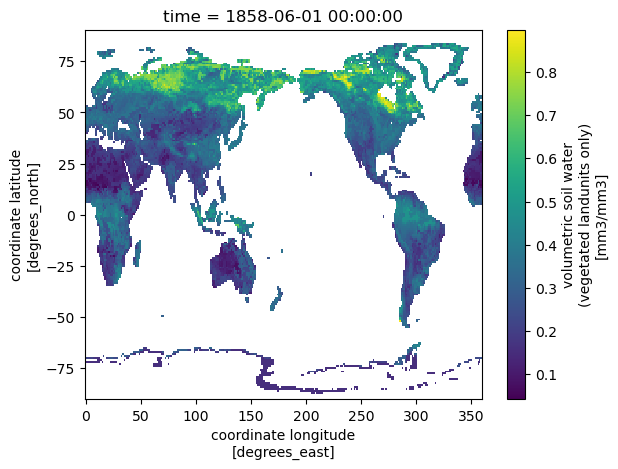

In [10]:
# --- quick plot gut check
ds_soil_lev['H2OSOI'].isel(time=100).plot()